In [1]:
import numpy as np
import seaborn as sns
from dask.distributed import Client
from distributed.deploy.local import LocalCluster
from pycalphad import Database,calculate,equilibrium,variables as v
from espei.utils import database_symbols_to_fit
import matplotlib.pyplot as plt
from collections import OrderedDict
import xarray as xr
import matplotlib.pyplot as plt
from pycalphad import calculate
from pycalphad.core.calculate import instantiate_models
import numpy as np

import xarray as xr
from espei.core_utils import get_data
from espei.utils import database_symbols_to_fit
from collections import OrderedDict
from scipy.stats import gaussian_kde
from collections import defaultdict 


In [2]:
def plot_property_sitefraction(dbf, comps, phaseL, phaseEQ, params, T, prop,
                  config=None, datasets=None, xlim=None,
                  xlabel=None, ylabel=None, yscale=None,
                  phase_label_dict=None,
                  cdict=None, figsize=None,cal_elem=None,cal_phase=None):

    """
    Plot a property of interest versus temperature with uncertainty
    bounds for all phases of interest

    Parameters
    ----------
    dbf : Database
        Thermodynamic database containing the relevant parameters
    comps : list
        Names of components to consider in the calculation
    phaseL : list
        Names of phases to plot properties for
    params : numpy array
        Array where the rows contain the parameter sets
        for the pycalphad equilibrium calculation
    T : list, array or x-array object
        Temperature values at which to plot the selected property
    prop : str
        property (or attribute in pycalphad terminology) to sample,
        e.g. GM for molar gibbs energy or H_MIX for the enthalpy of
        mixing
    cal_elem : str
        Element which need to be calculated 
    config : tuple, optional
        Sublattice configuration as a tuple, e.g. (“CU”, (“CU”, “MG”))
    datasets : espei.utils.PickleableTinyDB, optional
        Database of datasets to search for data
    xlims : list or tuple of float, optional
        List or tuple with two floats corresponding to the
        minimum and maximum molar composition of comp
    xlabel : str, optional
        plot x label
    ylabel : str, optional
        plot y label
    yscale : int or float, optional
        scaling factor to apply to property (e.g. to plot kJ/mol.
        instead of J/mol. choose yscale to be 0.001)
    phase_label_dict : dict, optional
        Dictionary with keys given by phase names and corresponding
        strings to use in plotting (e.g. to enable LaTeX labels)
    cdict : dict, optional
        Dictionary with phase names and corresponding
        colors
    figsize : tuple or list of int or float, optional
        Plot dimensions in inches

    Returns
    -------

    Examples
    --------
    >>> import numpy as np
    >>> import pduq.uq_plot as uq
    >>> from pycalphad import Database
    >>> dbf = Database('CU-MG_param_gen.tdb')
    >>> comps = ['MG', 'CU', 'VA']
    >>> phaseL = ['CUMG2', 'LIQUID']
    >>> params = np.loadtxt('params.npy')[: -1, :]
    >>> T = 650
    >>> prop = 'GM'
    >>> # Plot the molar gibbs energy of all phases in phaseL
    >>> # versus molar fraction of MG at 650K. This will have
    >>> # uncertainty intervals generated by the parameter sets
    >>> # in params
    >>> uq.plot_property(dbf, comps, phaseL, params, T, prop)
    """

    symbols_to_fit = database_symbols_to_fit(dbf)

    CI = 95
    model=instantiate_models(dbf, comps, phaseL)
    a=model[cal_phase].site_fractions
    num=len(a)/2
    nph = int(num)
    colorL = sns.color_palette("cubehelix", nph)
    markerL = 10*['o', 'D', '^', 'x', 'h', 's',
                  'v', '*', 'P', 'p', '>', 'd', '<']

    plt.figure(figsize=figsize)
    
    # compute uncertainty in property for each phase in list
    #for ii in range(nph):


        # for each parameter sample calculate the property
        # for each possible site occupancy ratios
    a_valueL=[]
    for j in range(int(num)): 
        compL = []
        for index in range(params.shape[0]):
            param_dict = {param_name: param for param_name, param
                              in zip(symbols_to_fit, params[index, :])}
            parameters = OrderedDict(sorted(param_dict.items(), key=str))
            #print(parameters)
            model=instantiate_models(dbf, comps, phaseL)
            a=model[cal_phase].site_fractions
            eq = equilibrium(dbf, comps, phaseEQ, {v.P: 101325, v.T: T, v.X(cal_elem): (0, 1, 0.05)},parameters=parameters)
            result=eq.Y.where(eq.Phase==cal_phase).squeeze()
        
            fin_re={}
            for i in range(len(eq.X.sel(component=cal_elem, vertex=0).values.squeeze())):
                pl_re=[]
                re=result[i].values
                re = re[np.logical_not(np.isnan(re))]
                pl_re.append(re)
                fin_re[str(i)]=pl_re
        
            value_re=[]
        
            
    
        #for j in range(int(num)):
            value=[]
            a_value=[]
            a_value.append(a[j*2])
            for key in fin_re.keys():
                if len(fin_re[key][0])>0:
                    value.append(fin_re[key][0][j*2])
                else:
                    value.append(0)
            if len(value_re)>0:
                value_re=np.vstack((value_re,value))
            else:
                value_re=value
            #print(value_re)       
        #compL = np.transpose(value_re)
            comp = np.transpose(value_re)
            compL += [comp]
        #print(compL)    
        # concatenate the calculate results in an xarray along
        # an axis named 'sample'
    #compC = xr.concat(compL, 'sample')
    #compC.coords['sample'] = np.arange(params.shape[0])
        

        # The composition vector is the same for all samples
        if hasattr(T, "__len__"):
                Xvals = T
        else:

            Xvals=eq.X.sel(component=cal_elem, vertex=0).values.squeeze()         
            Pvals = compL    
            if np.array(Xvals).size == 1:
                print('phase is a line compound')
                Xvals_ = np.array([Xvals-0.002, Xvals+0.002])
                Pvals_ = np.vstack([Pvals, Pvals]).T
            else:
            # find the lower hull of the property by finding
            # the configuration with the lowest value within
            # each interval. In each interval record the composition
            # and property
                Pvals_1= np.nan_to_num(Pvals)
            
                index=np.sum(Pvals_1, axis=1)
                index_=[]
                for ll in range(len(Pvals_1)):
                #if 0 in Pvals_1[ll] or index[ll]==0:
                    if index[ll]==0:
                        index_.append(ll)
                #print('index=',index)
                #print('index_=',index_)
                #print('Pvals_ori=',Pvals_1)
                #print('Pvals=',Pvals_1.shape)
                Pvals_=np.delete(Pvals_1,index_,0)
                #print('Pvals=',Pvals_)
                CI=100
                low, mid, high = np.percentile(
                 Pvals_, [0.5*(100-CI), 50, 100-0.5*(100-CI)], axis=0)
                #print('low',low)
                #print('high',high)
                #print('mean',mid)
            if cdict is not None:
                color = cdict[phase]
            else:
                color = colorL[j]

            #if phase_label_dict is not None:
            #    label = phase_label_dict[phase]
            #else:
            #    label = a_value
            Xvals_=Xvals
            #print('x',Xvals)
            plt.plot(Xvals_, mid, linestyle='-', color=color)
            plt.fill_between(
                np.atleast_1d(Xvals_), low, high, alpha=0.3, facecolor=color)
            
            result_data=[Xvals_,low,mid,high]
            np.save('results'+str(j)+'.npy',result_data)
        a_valueL += a_value
        #print(a_value)
        #print(a_valueL)
        
        # collect and plot experimental data

    if xlim is None:
        plt.xlim([Xvals_.min(), Xvals_.max()])
    else:
        plt.xlim(xlim)

    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(r'$X_{%s}$' % comps[0])

    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(prop + ' (' + unit + ')')
    plt.legend(a_valueL, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.tight_layout()

(0.48, 0.6)

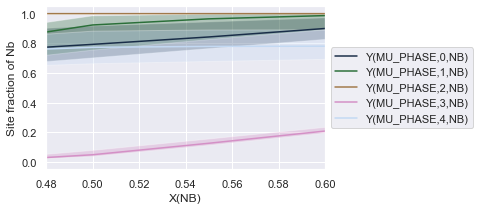

In [3]:
dbf = Database('mcmc_NBNI_10.tdb')
params = np.load('trace_NBNI_10.npy')[:, -1, :]
params = params.reshape(-1,params.shape[-1])
phaseL = ['MU_PHASE']
phaseEQ = ['MU_PHASE']
comps = ['NB', 'NI']  # species to consider
xlim=[0, 1]
T = 1273  # temperature in Kelvin
prop = 'Y'  # property of interest (molar Gibbs energy)
cal_elem = 'NB'
cal_phase = 'MU_PHASE'
xlabel = 'X(NB)'
ylabel = 'Site fraction of Nb'  # y-axis label
#yscale = 1e-3  # we want to scale the Gibbs energy to give kJ/mol.
# we can now plot the property. Note that phaseL, phase_label_dict,
# and cdict are defined in the phase diagram prediction example

plot_property_sitefraction(dbf, comps, phaseL, phaseEQ, params, T, prop,xlabel=xlabel,
                 ylabel=ylabel, cal_elem=cal_elem, cal_phase=cal_phase, xlim=xlim,
                 figsize=(5, 3))
plt.xlim(0.48,0.6)

In [29]:
site1=np.load('results4.npy')
print(site1)

[[1.00000000e-12 5.00000000e-02 1.00000000e-01 2.25854843e-01
  2.25854843e-01 2.31050898e-01 3.63204679e-01 3.63204679e-01
  4.00000000e-01 4.50000000e-01 5.00000000e-01 5.50000000e-01
  6.00000000e-01 6.50000000e-01 7.00000000e-01 7.50000000e-01
  8.00000000e-01 8.50000000e-01 9.00000000e-01 9.50000000e-01]
 [9.86627823e-16 2.08440346e-06 1.48656231e-07 2.10524772e-08
  6.07859533e-01 5.46643089e-01 5.46643089e-01 5.54294087e-01
  5.94148542e-01 6.33971240e-01 6.61881825e-01 6.77194133e-01
  6.91546378e-01 7.11350255e-01 7.42477944e-01 7.80545107e-01
  8.25468428e-01 8.80917190e-01 9.49104068e-01 9.96404529e-01]
 [1.50807356e-14 1.32157101e-05 3.46235124e-07 9.81204887e-01
  9.81259557e-01 9.99341585e-01 6.46723637e-01 6.48586427e-01
  6.88584348e-01 7.43808953e-01 7.72903883e-01 7.78928175e-01
  7.80432198e-01 7.84945787e-01 8.03543269e-01 8.40683744e-01
  8.88583826e-01 9.42578082e-01 9.87870792e-01 9.99237479e-01]
 [2.42428766e-13 1.08007948e-04 9.79680383e-01 9.90439249e-01
  9.9

In [1]:
y0=[]
y1=[]
y2=[]
y3=[]
y4=[]
y_site=[0.67,0.85,0.95,0.13,0.74,
0.89,1,0.89,0.07,0.77,
0.78,0.94,1,0.1,0.84,
0.85,0.99,1,0.12,0.81,
0.81,1,1,0.16,0.81]
x=[0.496,0.518,0.530,0.533,0.569]
for i in range(len(y_site)):
    if (i % 5) == 0:
        y0.append(float(y_site[i]))
    elif (i % 5) == 1:
        y1.append(float(y_site[i]))
    elif (i % 5) == 2:
        y2.append(float(y_site[i]))
    elif (i % 5) == 3:
        y3.append(float(y_site[i]))
    else:
        y4.append(float(y_site[i]))
print(y0)

[0.67, 0.89, 0.78, 0.85, 0.81]


/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(0.0, 1.05)

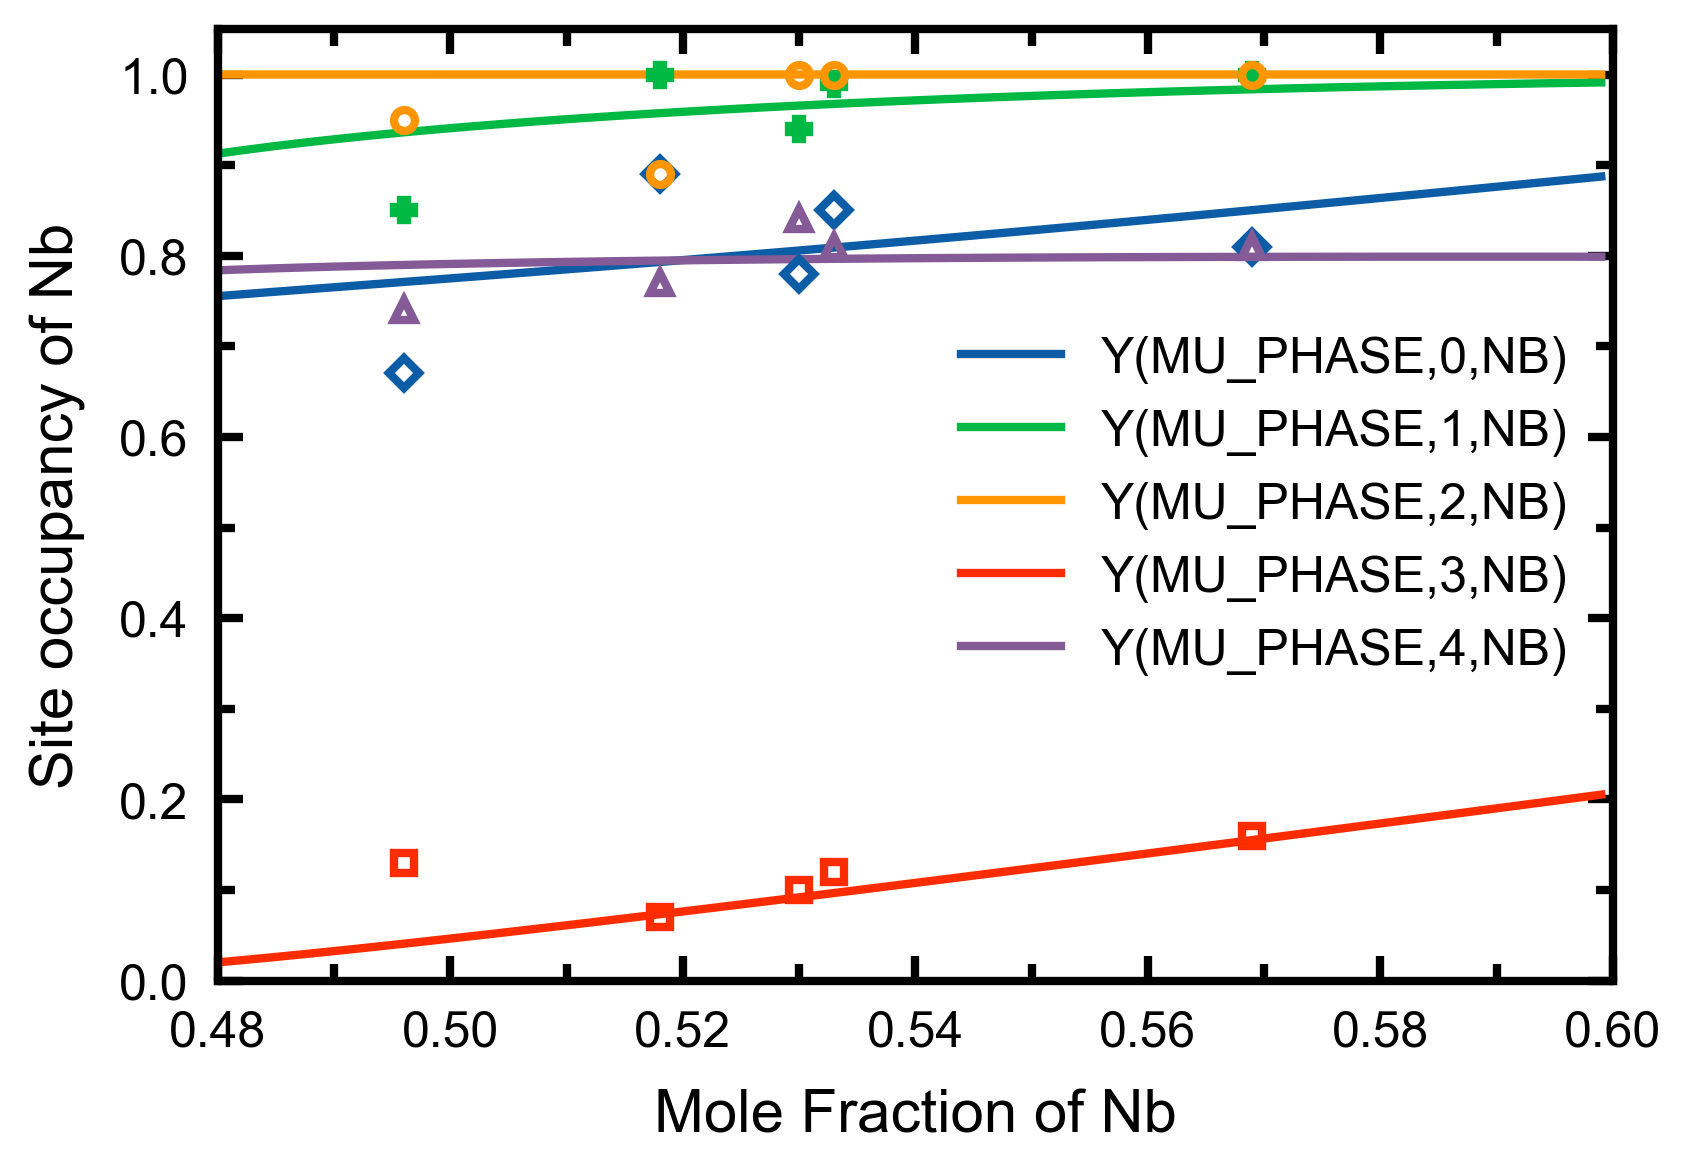

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, calculate,equilibrium, variables as v
from pycalphad.core.calculate import instantiate_models
from pycalphad.plot.utils import phase_legend
import numpy as np
plt.style.use('MQMQA_plot.mplstyle')
dbf = Database('Nb-Ni.tdb')
phases = ['MU_PHASE']
model=instantiate_models(dbf, ['NB', 'NI','VA'], ['MU_PHASE'])
a=model['MU_PHASE'].site_fractions

eq = equilibrium(dbf,  ['NB', 'NI','VA'], phases, {v.P: 101325, v.T: 1273, v.X('NB'): (0.48, 0.6, 0.001)})
result=eq.Y.where(eq.Phase=='MU_PHASE').squeeze()
from collections import defaultdict 
fin_re={}
for i in range(len(eq.X_NB)):
    pl_re=[]
    for j in range(len(a)):
        n=float(eq.X_NB[i].values)
        pl_re.append(float(result[i][0][j].values))
    fin_re[str(i)]=pl_re
value_re=[]
num=len(a)/2
a_value=[]
for j in range(int(num)):
    value=[]
    a_value.append(a[j*2])
    for key in fin_re.keys():
        value.append(fin_re[key][j*2])
    if len(value_re)>0:
        value_re=np.vstack((value_re,value))
    else:
        value_re=value
plt.plot(eq.X_NB.values,np.transpose(value_re))
plt.plot(x,y0,'d',label=i, marker=next(marker),markerfacecolor='none',color='#0C5DA5')
plt.plot(x,y1,'d',label=i, marker=next(marker),markerfacecolor='none',color='#00B945')
plt.plot(x,y2,'d',label=i, marker=next(marker),markerfacecolor='none',color='#FF9500')
plt.plot(x,y3,'d',label=i, marker=next(marker),markerfacecolor='none',color='#FF2C00')
plt.plot(x,y4,'d',label=i, marker=next(marker),markerfacecolor='none',color='#845B97')
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.xlabel('Mole Fraction of Nb')
plt.ylabel('Site occupancy of Nb')
plt.legend(a_value)
plt.xlim(0.48,0.6)
plt.ylim(0,1.05)

In [7]:
import itertools
import matplotlib
marker = itertools.cycle(('o', 's', '^', 'v', 'd','<', '>', '*','1','X','D','P')) 
plt.figure(dpi=600)
plt.style.use('MQMQA_plot.mplstyle')
plt.plot(site1[0], site1[2], linestyle='-',color='#9e9e9e')
plt.plot(x,y4,'d',label=i, marker=next(marker),markerfacecolor='none',color='black')
plt.fill_between(np.atleast_1d(site1[0]),site1[1],site1[3], alpha=0.3,color='#9e9e9e')
#plt.axes().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(20))
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.xlim(0.48,0.6)

NameError: name 'site1' is not defined

<Figure size 1800x1260 with 0 Axes>

In [2]:
site1=np.load('resultsHMIX.npy')
print(site1)

[[ 1.00050025e-02  2.00100050e-02  3.00150075e-02  4.03906987e-02
   5.03627265e-02  6.05302651e-02  7.06904951e-02  8.05402701e-02
   9.08054930e-02  1.00550275e-01  1.11055528e-01  1.21060530e-01
   1.31065533e-01  1.41070535e-01  1.51075538e-01  1.61580790e-01
   1.71585793e-01  1.81630801e-01  1.91595798e-01  2.01600800e-01
   2.12106053e-01  2.22160947e-01  2.32170220e-01  2.42121061e-01
   2.52300302e-01  2.62527011e-01  2.72636318e-01  2.82641321e-01
   2.85642821e-01  2.93146573e-01  3.03151576e-01  3.13156578e-01
   3.23240960e-01  3.33666833e-01  3.43671836e-01  3.53560171e-01
   3.63681841e-01  3.73862013e-01  3.84192096e-01  3.94197099e-01
   4.04202101e-01  4.14207104e-01  4.24464531e-01  4.34717359e-01
   4.44722361e-01  4.54567876e-01  4.64732366e-01  4.75237619e-01
   4.85007642e-01  4.95247624e-01  5.05252626e-01  5.15257629e-01
   5.25262631e-01  5.35416527e-01  5.45772886e-01  5.55777889e-01
   5.65782891e-01  5.75787894e-01  5.85991677e-01  5.96298149e-01
   6.06081

/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


(0.0, 1.0)

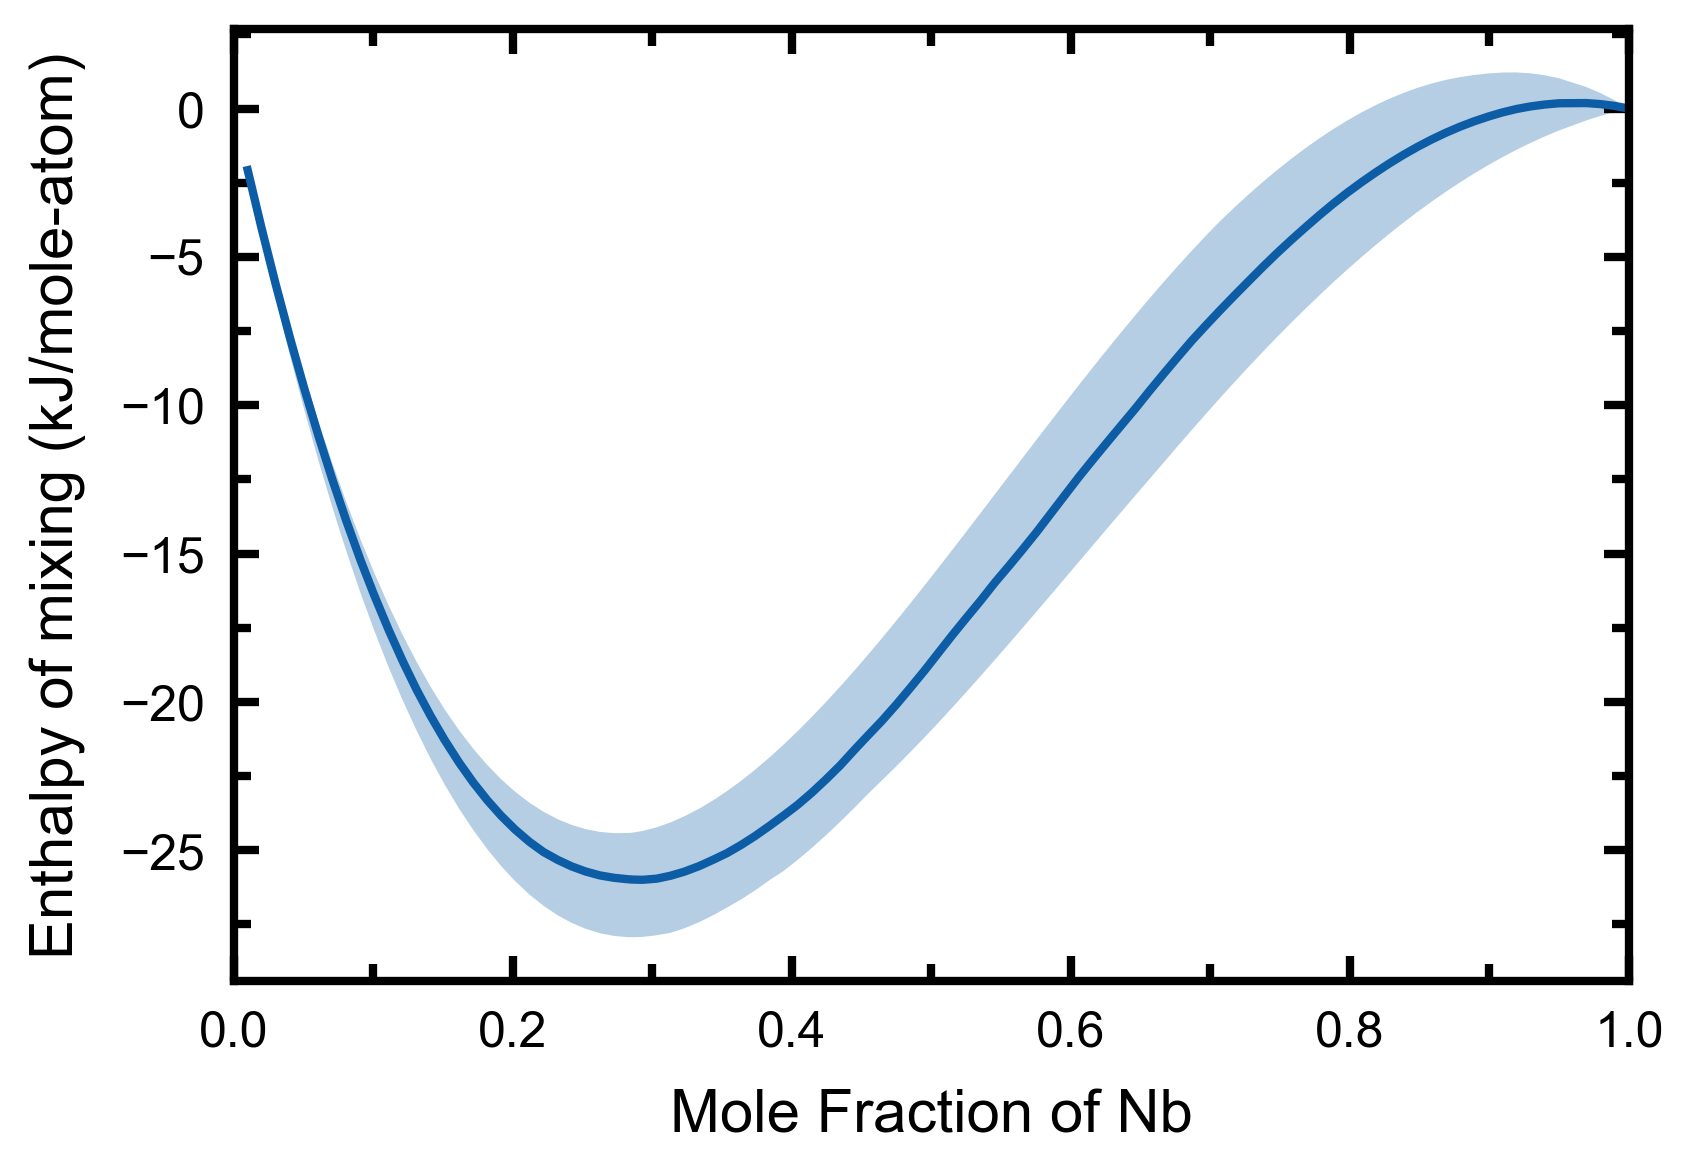

In [4]:
import itertools
import matplotlib
marker = itertools.cycle(('o', 's', '^', 'v', 'd','<', '>', '*','1','X','D','P')) 
plt.figure(dpi=600)
plt.style.use('MQMQA_plot.mplstyle')
plt.plot(site1[0], site1[2], linestyle='-')
plt.ylabel('Enthalpy of mixing (kJ/mole-atom)')  # y-axis label
plt.xlabel('Mole Fraction of Nb')
#plt.plot(x,y4,'d',label=i, marker=next(marker),markerfacecolor='none',color='black')
plt.fill_between(np.atleast_1d(site1[0]),site1[1],site1[3], alpha=0.3)
#plt.axes().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(20))
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.xlim(0,1)



In [34]:
list(dbf.phases.keys())

['BCC_A2',
 'BCC_B2',
 'DELTA',
 'FCC_A1',
 'HCP_A3',
 'LIQUID',
 'MU_PHASE',
 'NBNI8']

starting HM_MIX evaluations for the LIQUID phase


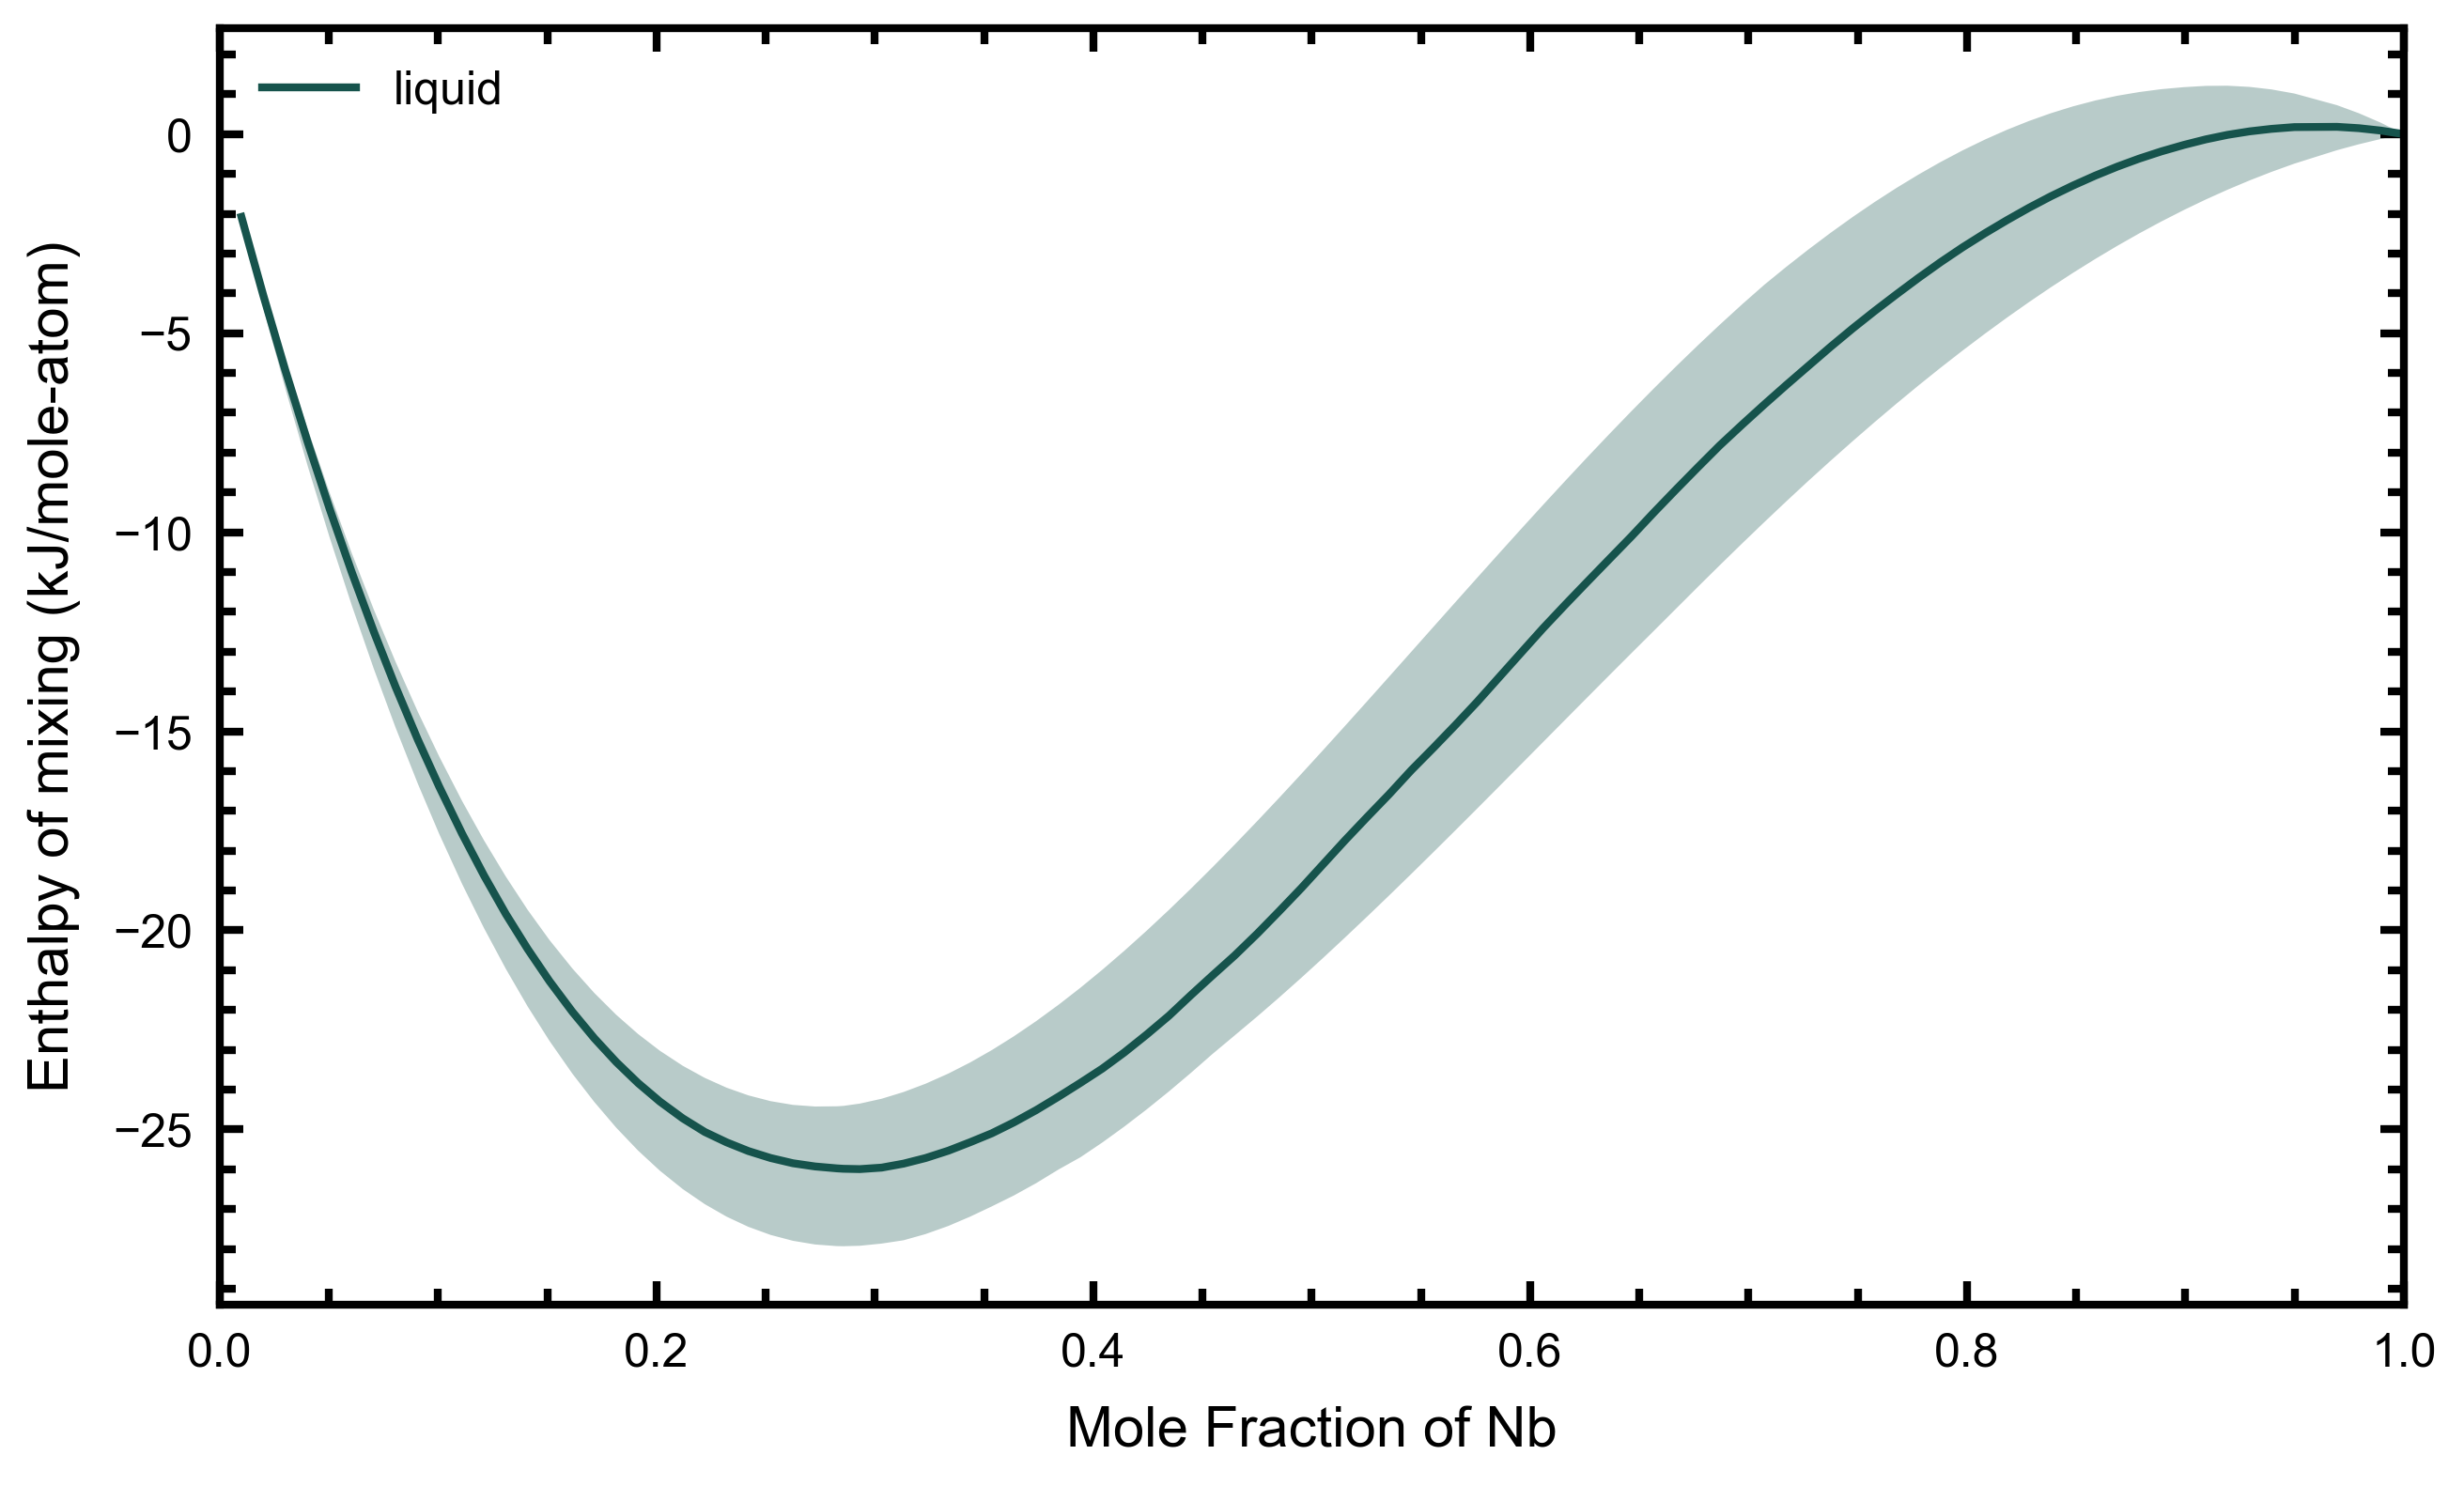

In [14]:
from pduq.uq_plot import plot_property
T = 1823  # temperature in Kelvin
prop = 'HM_MIX'  # property of interest (molar enthalpy of mixing
dbf = Database('mcmc_NBNI_10.tdb')
params = np.load('trace_NBNI_10.npy')[:, -1, :]
params = params.reshape(-1,params.shape[-1])
ylabel = 'Enthalpy of mixing (kJ/mole-atom)'  # y-axis label
xlabel = 'Mole Fraction of Nb'
phaseL = ['LIQUID']
comps = ['NB', 'NI']  # species to consider
yscale = 1e-3  # we want to scale the Gibbs energy to give kJ/mol.
nph = len(phaseL)
colorL = sns.color_palette("cubehelix", nph+2)
cdict = {}
for ii in range(nph):
    cdict[phaseL[ii]] = colorL[ii]
phase_label_dict = {
    'LIQUID':'liquid','MU_PHASE':'liquid'}
# we can now plot the property. Note that phaseL, phase_label_dict,
# and cdict are defined in the phase diagram prediction example
plt.style.use('MQMQA_plot.mplstyle')
plot_property1(dbf, comps, phaseL, params, T, prop,
                 phase_label_dict=phase_label_dict,xlabel=xlabel,
                 ylabel=ylabel, yscale=yscale, cdict=cdict,
                 xlim=[0, 1], figsize=(5, 3))
plt.style.use('MQMQA_plot.mplstyle')

In [13]:
def plot_property1(dbf, comps, phaseL, params, T, prop,
                  config=None, datasets=None, xlim=None,
                  xlabel=None, ylabel=None, yscale=None,
                  phase_label_dict=None,
                  unit='kJ/mol.', cdict=None, figsize=None):

    """
    Plot a property of interest versus temperature with uncertainty
    bounds for all phases of interest

    Parameters
    ----------
    dbf : Database
        Thermodynamic database containing the relevant parameters
    comps : list
        Names of components to consider in the calculation
    phaseL : list
        Names of phases to plot properties for
    params : numpy array
        Array where the rows contain the parameter sets
        for the pycalphad equilibrium calculation
    T : list, array or x-array object
        Temperature values at which to plot the selected property
    prop : str
        property (or attribute in pycalphad terminology) to sample,
        e.g. GM for molar gibbs energy or H_MIX for the enthalpy of
        mixing
    config : tuple, optional
        Sublattice configuration as a tuple, e.g. (“CU”, (“CU”, “MG”))
    datasets : espei.utils.PickleableTinyDB, optional
        Database of datasets to search for data
    xlims : list or tuple of float, optional
        List or tuple with two floats corresponding to the
        minimum and maximum molar composition of comp
    xlabel : str, optional
        plot x label
    ylabel : str, optional
        plot y label
    yscale : int or float, optional
        scaling factor to apply to property (e.g. to plot kJ/mol.
        instead of J/mol. choose yscale to be 0.001)
    phase_label_dict : dict, optional
        Dictionary with keys given by phase names and corresponding
        strings to use in plotting (e.g. to enable LaTeX labels)
    unit : str, optional
        Unit to plot on the y-axis for the property of interest
    cdict : dict, optional
        Dictionary with phase names and corresponding
        colors
    figsize : tuple or list of int or float, optional
        Plot dimensions in inches

    Returns
    -------

    Examples
    --------
    >>> import numpy as np
    >>> import pduq.uq_plot as uq
    >>> from pycalphad import Database
    >>> dbf = Database('CU-MG_param_gen.tdb')
    >>> comps = ['MG', 'CU', 'VA']
    >>> phaseL = ['CUMG2', 'LIQUID']
    >>> params = np.loadtxt('params.npy')[: -1, :]
    >>> T = 650
    >>> prop = 'GM'
    >>> # Plot the molar gibbs energy of all phases in phaseL
    >>> # versus molar fraction of MG at 650K. This will have
    >>> # uncertainty intervals generated by the parameter sets
    >>> # in params
    >>> uq.plot_property(dbf, comps, phaseL, params, T, prop)
    """

    symbols_to_fit = database_symbols_to_fit(dbf)

    CI = 95
    nph = len(phaseL)
    colorL = sns.color_palette("cubehelix", nph)
    markerL = 10*['o', 'D', '^', 'x', 'h', 's',
                  'v', '*', 'P', 'p', '>', 'd', '<']
    plt.style.use('MQMQA_plot.mplstyle')
    plt.figure(figsize=figsize)

    # compute uncertainty in property for each phase in list
    for ii in range(nph):
        phase = phaseL[ii]
        print('starting', prop, 'evaluations for the', phase, 'phase')

        # for each parameter sample calculate the property
        # for each possible site occupancy ratios
        compL = []
        for index in range(params.shape[0]):
            param_dict = {param_name: param for param_name, param
                          in zip(symbols_to_fit, params[index, :])}
            parameters = OrderedDict(sorted(param_dict.items(), key=str))
            comp = calculate(
                dbf, comps, phase,
                P=101325, T=T, output=prop, parameters=parameters)
            compL += [comp]

        # concatenate the calculate results in an xarray along
        # an axis named 'sample'
        compC = xr.concat(compL, 'sample')
        compC.coords['sample'] = np.arange(params.shape[0])

        # The composition vector is the same for all samples
        if hasattr(T, "__len__"):
            Xvals = T
        else:
            Xvals = comp.X.sel(component=comps[0]).values.squeeze()
        Pvals = compC[prop].where(compC.Phase == phase).values.squeeze()

        if np.array(Xvals).size == 1:
            print('phase is a line compound')
            Xvals_ = np.array([Xvals-0.002, Xvals+0.002])
            Pvals_ = np.vstack([Pvals, Pvals]).T
        else:
            # find the lower hull of the property by finding
            # the configuration with the lowest value within
            # each interval. In each interval record the composition
            # and property
            indxL = np.array([])
            # Xbnds = np.arange(0, 1.01, 0.01)
            Xbnds = np.linspace(Xvals.min(), Xvals.max(), 100)
            for lb, ub in zip(Xbnds[:-1], Xbnds[1:]):
                # print('lb: ', lb, ', ub: ', ub)
                boolA = (lb <= Xvals)*(Xvals < ub)
                if boolA.sum() == 0:
                    continue
                indxA = np.arange(boolA.size)[boolA]
                P_ = Pvals[0, boolA]
                indxL = np.append(indxL, indxA[P_.argmin()])
                # indxL = np.append(indxL, indxA[P_.argmax()])
            indxL = indxL.astype('int32')

            if indxL.size == 1:
                print('only one point found')
                Xvals_ = Xvals[np.asscalar(indxL)]
                Pvals_ = Pvals[:, np.asscalar(indxL)]
            else:
                Xvals_ = Xvals[indxL]
                Pvals_ = Pvals[:, indxL]

        # Xvals_ = Xvals
        # Pvals_ = Pvals
        # for ii in range(params.shape[0]):
        #     plt.plot(Xvals_, Pvals_[ii, :], 'k-', linewidth=0.5, alpha=0.1)
        # plt.show()

        if yscale is not None:
            Pvals_ *= yscale

        low, mid, high = np.percentile(
            Pvals_, [0.5*(100-CI), 50, 100-0.5*(100-CI)], axis=0)

        if cdict is not None:
            color = cdict[phase]
        else:
            color = colorL[ii]

        if phase_label_dict is not None:
            label = phase_label_dict[phase]
        else:
            label = phase

        plt.plot(Xvals_, mid, linestyle='-', color=color, label=label)
        plt.fill_between(
            np.atleast_1d(Xvals_), low, high, alpha=0.3, facecolor=color)
        result_data=[Xvals_,low,mid,high]
        np.save('results'+'HMIX'+'.npy',result_data)
        # collect and plot experimental data
        if config is not None and datasets is not None:
            symmetry = None
            data = get_data(
                comps, phase, config, symmetry, datasets, prop)
            print(data)
            for data_s, marker in zip(data, markerL):
                occupancies = data_s['solver']['sublattice_occupancies']
                # at the moment this needs to be changed manually
                X_vec = [row[0][0] for row in occupancies]
                values = np.squeeze(data_s['values'])

                if yscale is not None:
                    values *= yscale

                plt.plot(
                    X_vec, values, linestyle='', marker=marker,
                    markerfacecolor='none', markeredgecolor=color,
                    markersize=6, alpha=0.9, label=data_s['reference'])

    if xlim is None:
        plt.xlim([Xvals_.min(), Xvals_.max()])
    else:
        plt.xlim(xlim)

    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(r'$X_{%s}$' % comps[0])

    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(prop + ' (' + unit + ')')
    plt.style.use('MQMQA_plot.mplstyle')
    plt.legend()
    #plt.tight_layout()


# re=np.load('results3.npy')
print(re)
print(re[1]-re[-1])
plt.fill_between(
                np.atleast_1d(re[0]), re[1], re[-1], alpha=0.3)
plt.show()

In [88]:
dbf = Database('PDZN_B2_mcmc_10-39.tdb')
params = np.load('trace_10-39.npy')[:, -1, :]
params = params.reshape(-1,params.shape[-1])
phaseL = ['GAMMA']
phaseEQ = ['PDZN2', 'LIQUID','GAMMA','HCP_ZN','PD9ZN91_ETA']
comps = ['PD', 'ZN']  # species to consider
model=instantiate_models(dbf, comps, phaseL)
a=model[cal_phase].site_fractions
num=len(a)/2
nph = int(num)
colorL = sns.color_palette("cubehelix", nph)

print(colorL)

[(0.08605633600581405, 0.23824692404212, 0.30561236308077167), (0.3292772926340829, 0.4762845556584382, 0.1837155549758328), (0.8146245329198283, 0.49548316572322215, 0.5752525936416857), (0.7587183008012618, 0.7922069335474338, 0.9543861221913403)]
